In [159]:
# !pip uninstall torch-geometric -y
# !pip uninstall torch-scatter -y
# !pip uninstall torch-sparse -y

# Install necessary dependencies
# !pip install torch-scatter 
# !pip install torch-sparse 

# # Install torch-geometric
# !pip install torch-geometric 


In [160]:
from torch_geometric.utils import train_test_split_edges, to_networkx

In [161]:
from torch_geometric.datasets import TUDataset

# Mutag dataset
dataset = TUDataset(root='/tmp/MUTAG', name='MUTAG')

# Total the number of graphs
print(f"Number of graphs in the dataset: {len(dataset)}")

# Access individual graphs
for i, data in enumerate(dataset[:30]):  # analyze first 5 graphs
    print(f"\nGraph {i}:")
    print(f"Number of nodes: {data.num_nodes}")
    print(f"Number of edges: {data.num_edges}")
    print(f"Node feature matrix shape: {data.x.shape}")
    print(f"Edge index shape: {data.edge_index.shape}")
    print(f"Label: {data.y.item()}")

print(len(dataset))


Number of graphs in the dataset: 188

Graph 0:
Number of nodes: 17
Number of edges: 38
Node feature matrix shape: torch.Size([17, 7])
Edge index shape: torch.Size([2, 38])
Label: 1

Graph 1:
Number of nodes: 13
Number of edges: 28
Node feature matrix shape: torch.Size([13, 7])
Edge index shape: torch.Size([2, 28])
Label: 0

Graph 2:
Number of nodes: 13
Number of edges: 28
Node feature matrix shape: torch.Size([13, 7])
Edge index shape: torch.Size([2, 28])
Label: 0

Graph 3:
Number of nodes: 19
Number of edges: 44
Node feature matrix shape: torch.Size([19, 7])
Edge index shape: torch.Size([2, 44])
Label: 1

Graph 4:
Number of nodes: 11
Number of edges: 22
Node feature matrix shape: torch.Size([11, 7])
Edge index shape: torch.Size([2, 22])
Label: 0

Graph 5:
Number of nodes: 28
Number of edges: 62
Node feature matrix shape: torch.Size([28, 7])
Edge index shape: torch.Size([2, 62])
Label: 1

Graph 6:
Number of nodes: 16
Number of edges: 34
Node feature matrix shape: torch.Size([16, 7])
Ed

In [162]:
import torch

# what are the labels?

all_labels = [data.y.item() for data in dataset]  
unique_classes = torch.unique(torch.tensor(all_labels))

print(f"Classes in the dataset: {unique_classes}")
print(f"Number of unique classes: {len(unique_classes)}")


Classes in the dataset: tensor([0, 1])
Number of unique classes: 2


In [163]:
import torch
from torch_geometric.data import DataLoader
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_dense_adj

In [240]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, SAGPooling, global_max_pool
from torch_geometric.utils import to_dense_adj
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv


# Encoder
class VariationalGraphEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VariationalGraphEncoder, self).__init__()
        self.gat1 = GATConv(in_channels, 2 * out_channels, heads=4)
        self.gat2 = GATConv(8 * out_channels, 2 * out_channels, heads=4)
        self.conv_mu = GATConv(8 * out_channels, out_channels)
        self.conv_logstd = GATConv(8 * out_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = F.elu(self.gat1(x, edge_index))
        x = F.elu(self.gat2(x, edge_index))
        mu = self.conv_mu(x, edge_index)
        logstd = self.conv_logstd(x, edge_index)
        # mu_graph = global_mean_pool(mu, batch)
        # logstd_graph = global_mean_pool(logstd, batch)
        mu_graph = global_max_pool(mu, batch)
        logstd_graph = global_max_pool(logstd, batch)
        return mu_graph, logstd_graph


In [241]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn

## GNN BASED
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn

class GraphDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, predict_node_features=False, node_feature_dim=None):
        """
        Decoder for graph reconstruction from a graph-level latent embedding.
        
        Args:
            latent_dim (int): Dimension of the graph-level latent embedding.
            hidden_dim (int): Dimension of the hidden layers.
            predict_node_features (bool): Whether to predict node features along with the adjacency matrix.
            node_feature_dim (int): Optional, the dimension of the node features to reconstruct.
        """
        super(GraphDecoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.predict_node_features = predict_node_features

        # Linear transformation for latent vector to node-level embeddings
        self.node_init = nn.Linear(latent_dim, hidden_dim)

        # GCN layers to process node-level embeddings
        self.gcn1 = pyg_nn.GCNConv(hidden_dim, hidden_dim)
        self.gcn2 = pyg_nn.GCNConv(hidden_dim, hidden_dim)

        # Output layer for adjacency matrix prediction
        self.adj_output = nn.Linear(hidden_dim, 1)

        # Optional: Output layer for node feature prediction
        if self.predict_node_features and node_feature_dim is not None:
            self.node_feat_output = nn.Linear(hidden_dim, node_feature_dim)

    def forward(self, z_i, num_nodes):
        """
        Forward pass for decoding the graph from the latent space.

        Args:
            z_i (torch.Tensor): Latent representation for graph (num_nodes, latent_dim).
            num_nodes (int): The number of nodes in the current graph.

        Returns:
            adj_pred (torch.Tensor): Predicted adjacency matrix of shape (num_nodes, num_nodes).
            node_features_pred (torch.Tensor, optional): Predicted node features if enabled.
        """
        # Step 1: Generate node embeddings from the latent vector
        node_embeddings = self.node_init(z_i)  # Shape: (num_nodes, hidden_dim)

        # Step 2: Process node embeddings through GCN layers
        edge_index = torch.combinations(torch.arange(num_nodes), r=2).T  # All-pairs connectivity
        edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)  # Symmetric edges

        x = F.relu(self.gcn1(node_embeddings, edge_index))
        x = F.relu(self.gcn2(x, edge_index))

        # Step 3: Predict adjacency matrix
        adj_pred = torch.sigmoid(torch.matmul(x, x.T))  # (num_nodes, num_nodes)

        # Optional: Predict node features if required
        if self.predict_node_features:
            node_features_pred = self.node_feat_output(x)
            return adj_pred, node_features_pred
        else:
            return adj_pred



## ATTENTION BASED
# class GraphDecoder(nn.Module):
#     def __init__(self, input_dim, hidden_dim, num_heads=4, dropout=0.0, normalize_embeddings=False):
#         super(GraphDecoder, self).__init__()
#         self.normalize_embeddings = normalize_embeddings
#         self.num_heads = num_heads

#         # Define linear layers for query, key, and value projections
#         self.query_proj = nn.Linear(input_dim, hidden_dim)
#         self.key_proj = nn.Linear(input_dim, hidden_dim)
#         self.value_proj = nn.Linear(input_dim, hidden_dim)

#         # Output layer
#         self.output_layer = nn.Linear(hidden_dim, input_dim)

#         # Dropout and activation function
#         self.dropout = nn.Dropout(dropout)
#         self.activation = nn.LeakyReLU(negative_slope=0.01)

#         # Multi-head scaling
#         self.scale_factor = torch.sqrt(torch.FloatTensor([hidden_dim // num_heads]))

#     def forward(self, node_features, num_nodes):
#         """
#         Forward pass of the GraphDecoder with self-attention.

#         Args:
#             node_features (torch.Tensor): Input latent features of shape (num_nodes, input_dim).
#             num_nodes (int): Number of nodes in the graph.

#         Returns:
#             adj_pred (torch.Tensor): Predicted adjacency matrix of shape (num_nodes, num_nodes).
#         """

#         # Project node features to query, key, and value
#         queries = self.query_proj(node_features)
#         keys = self.key_proj(node_features)
#         values = self.value_proj(node_features)

#         # Compute attention scores: (num_nodes, hidden_dim) x (hidden_dim, num_nodes) -> (num_nodes, num_nodes)
#         attention_scores = torch.matmul(queries, keys.T) / self.scale_factor

#         # Apply softmax to get attention weights
#         attention_weights = F.softmax(attention_scores, dim=-1)

#         # Weighted aggregation of values using attention weights
#         attention_output = torch.matmul(attention_weights, values)

#         # Apply dropout and activation function to the attention output
#         h1 = self.activation(attention_output)
#         h1 = self.dropout(h1)

#         # Output embeddings
#         output_embeddings = self.output_layer(h1)

#         # Optionally normalize embeddings
#         if self.normalize_embeddings:
#             output_embeddings = F.normalize(output_embeddings, p=2, dim=1)

#         # Compute pairwise similarities for adjacency prediction
#         adj_pred = torch.matmul(output_embeddings, output_embeddings.T)

#         # Ensure adj_pred is of shape (num_nodes, num_nodes)
#         adj_pred = adj_pred[:num_nodes, :num_nodes]

#         # Scale predictions to stabilize values
#         adj_pred_scaled = adj_pred / adj_pred.std() if adj_pred.std() > 0 else adj_pred

#         # Apply sigmoid for probabilities
#         adj_pred = torch.sigmoid(adj_pred_scaled)

#         return adj_pred

## LINEAR

# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class GraphDecoder(nn.Module):
#     def __init__(self, input_dim, hidden_dim, dropout=0.0, normalize_embeddings=False):
#         super(GraphDecoder, self).__init__()
#         self.normalize_embeddings = normalize_embeddings

#         self.hidden_layer1 = nn.Linear(input_dim, hidden_dim)
#         self.hidden_layer2 = nn.Linear(hidden_dim, hidden_dim)
#         self.output_layer = nn.Linear(hidden_dim, input_dim)

#         self.dropout = nn.Dropout(dropout)
#         self.activation = nn.LeakyReLU(negative_slope=0.01)

#     def forward(self, node_features, num_nodes):
#         """
#         Forward pass of the GraphDecoder.

#         Args:
#             node_features (torch.Tensor): Input latent features of shape (num_nodes, input_dim).
#             num_nodes (int): Number of nodes in the graph.

#         Returns:
#             adj_pred (torch.Tensor): Predicted adjacency matrix of shape (num_nodes, num_nodes).
#         """
#         # Ensure that node_features is of shape (num_nodes, input_dim)
#         assert node_features.shape[0] == num_nodes, f"Expected num_nodes ({num_nodes}) but got {node_features.shape[0]}"

#         # First hidden layer
#         h1 = self.hidden_layer1(node_features)
#         h1 = self.activation(h1)
#         h1 = self.dropout(h1)

#         # Second hidden layer
#         h2 = self.hidden_layer2(h1)
#         h2 = self.activation(h2)
#         h2 = self.dropout(h2)

#         # Output embeddings
#         output_embeddings = self.output_layer(h2)

#         # Optionally normalize embeddings
#         if self.normalize_embeddings:
#             output_embeddings = F.normalize(output_embeddings, p=2, dim=1)

#         # Compute pairwise similarities for adjacency prediction
#         adj_pred = torch.matmul(output_embeddings, output_embeddings.T)

#         # Ensure adj_pred is of shape (num_nodes, num_nodes)
#         adj_pred = adj_pred[:num_nodes, :num_nodes]

#         # Scale predictions to stabilize values
#         adj_pred_scaled = adj_pred / adj_pred.std() if adj_pred.std() > 0 else adj_pred

#         # Apply sigmoid for probabilities
#         adj_pred = torch.sigmoid(adj_pred_scaled)

#         return adj_pred


In [253]:
# # Treat adjacency matrix reconstruction as a binary classification task (edge exists or not).
# # Use Binary Cross-Entropy (BCE) for the reconstruction loss
def vae_loss(adj_true, adj_pred, mu, logstd):

    loss_fn = nn.BCEWithLogitsLoss()

    # Reconstruction Loss (Binary Cross-Entropy)
    recon_loss = loss_fn(adj_true, adj_pred)

    # KL Divergence
    kl_divergence = -0.5 * torch.mean(1 + 2 * logstd - mu.pow(2) - torch.exp(2 * logstd))

    # Combine losses
    alpha = 0.01  # Weight for KL divergence


    # print(f"Recon Loss: {recon_loss.item():.4f}, KL Div: {kl_divergence.item():.4f}")

    return recon_loss + alpha * kl_divergence


In [254]:
def train(loader):
    encoder.train()
    decoder.train()
    total_loss = 0

    for batch_idx, data in enumerate(loader):
        # optimizer.zero_grad()

        # Encode the graph into a latent representation
        mu, logstd = encoder(data.x, data.edge_index, data.batch)
        z = mu + torch.randn_like(mu) * torch.exp(logstd)  # Reparameterization trick

        batch_loss = 0
        for i in range(data.num_graphs):
            num_nodes = (data.batch == i).sum().item()  # Number of nodes in the ith graph
            if num_nodes == 0:
                continue  # Skip empty graphs

            # Filter edges for the current graph
            mask = (data.batch[data.edge_index[0]] == i) & (data.batch[data.edge_index[1]] == i)
            valid_edges = data.edge_index[:, mask]

            # Reindex nodes
            node_mask = (data.batch == i).nonzero(as_tuple=False).squeeze()
            node_map = {node.item(): idx for idx, node in enumerate(node_mask)}
            reindexed_edges = valid_edges.clone()
            reindexed_edges[0] = valid_edges[0].apply_(lambda x: node_map[x])
            reindexed_edges[1] = valid_edges[1].apply_(lambda x: node_map[x])

            # Convert to dense adjacency matrix
            adj_true = to_dense_adj(reindexed_edges, max_num_nodes=num_nodes).squeeze(0)

            # Ensure that the latent code z[i] is expanded to (num_nodes, input_dim)
            # Repeat the latent code for each node in the graph
            z_i = z[i].unsqueeze(0).repeat(num_nodes, 1)  # Repeat z[i] for each node

            # Decode adjacency matrix
            adj_pred = decoder(z_i, num_nodes)

            # Ensure adjacency matrices match
            adj_pred = adj_pred[:num_nodes, :num_nodes]
            adj_true = adj_true[:num_nodes, :num_nodes]

            # print(f"TRAIN, adj_pred:\n{adj_pred}")
            # print(f"TRAIN, adj_true:\n{adj_true}")


            # # Print shapes and loss-related details
            # print(f"TRAIN, Graph {i}: adj_pred shape = {adj_pred.shape}, adj_true shape = {adj_true.shape}")
            # print(f"TRAIN, mu[{i}] mean = {mu[i].mean().item():.4f}, logstd[{i}] mean = {logstd[i].mean().item():.4f}")

            # Compute loss
            loss = vae_loss(adj_true, adj_pred, mu[i], logstd[i]) /num_nodes
            # print(f"TRAIN, Unnormalized Loss: {loss.item()*num_nodes:.4f}, num_nodes = {num_nodes}")
            # print(f"TRAIN, Normalized Loss: {loss.item():.4f}")

            batch_loss += loss

        # Backpropagation
        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item()
    
    return total_loss / len(loader)


In [255]:
def validate(loader):
    encoder.eval()  # Set encoder to evaluation mode
    decoder.eval()  # Set decoder to evaluation mode
    total_loss = 0

    with torch.no_grad():  # Disable gradient computation
        for batch_idx, data in enumerate(loader):
            # Encode the graph into a latent representation
            mu, logstd = encoder(data.x, data.edge_index, data.batch)
            z = mu + torch.randn_like(mu) * torch.exp(logstd) # need to Skip reparameterization (use mean during validation)??

            batch_loss = 0
            for i in range(data.num_graphs):
                num_nodes = (data.batch == i).sum().item()  # Number of nodes in the ith graph
                if num_nodes == 0:
                    continue  # Skip empty graphs

                # Filter edges for the current graph
                mask = (data.batch[data.edge_index[0]] == i) & (data.batch[data.edge_index[1]] == i)
                valid_edges = data.edge_index[:, mask]

                # Reindex nodes
                node_mask = (data.batch == i).nonzero(as_tuple=False).squeeze()
                node_map = {node.item(): idx for idx, node in enumerate(node_mask)}
                reindexed_edges = valid_edges.clone()
                reindexed_edges[0] = valid_edges[0].apply_(lambda x: node_map[x])
                reindexed_edges[1] = valid_edges[1].apply_(lambda x: node_map[x])

                # Convert to dense adjacency matrix
                adj_true = to_dense_adj(reindexed_edges, max_num_nodes=num_nodes).squeeze(0)

                # Ensure that the latent code z[i] is expanded to (num_nodes, input_dim)
                z_i = z[i].unsqueeze(0).repeat(num_nodes, 1)  # Repeat z[i] for each node

                # Decode adjacency matrix
                adj_pred = decoder(z_i, num_nodes)

                # Ensure adjacency matrices match
                adj_pred = adj_pred[:num_nodes, :num_nodes]
                adj_true = adj_true[:num_nodes, :num_nodes]

                # print(f"VAL, adj_pred:\n{adj_pred}")
                # print(f"VAL, adj_true:\n{adj_true}")


                # # Print shapes and loss-related details
                # print(f"VAL, Graph {i}: adj_pred shape = {adj_pred.shape}, adj_true shape = {adj_true.shape}")
                # print(f"VAL, mu[{i}] mean = {mu[i].mean().item():.4f}, logstd[{i}] mean = {logstd[i].mean().item():.4f}")

                # Compute loss
                loss = vae_loss(adj_true, adj_pred, mu[i], logstd[i]) / num_nodes # Normalize Loss by Graph Size
                # print(f"VAL, Unnormalized Loss: {loss.item()*num_nodes:.4f}, num_nodes = {num_nodes}")
                # print(f"VAL, Normalized Loss: {loss.item():.4f}")
                batch_loss += loss

            total_loss += batch_loss.item()
        return total_loss / len(loader)  # Average loss over the loader


In [256]:
# Load dataset and initialize model, optimizer, etc.
dataset = TUDataset(root='/tmp/MUTAG', name='MUTAG')

# Split dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [257]:
# print(dir(train_dataset))
# print(dir(val_dataset.dataset))

# print(f"Train dataset: {val_dataset.dataset.num_classes}")
# print(f"Validation dataset: {val_dataset.dataset.num_classes}")
# # print(f"Training dataset: avg nodes = {train_dataset.avg_nodes}, avg edges = {train_dataset.avg_edges}")
# # print(f"Validation dataset: avg nodes = {val_dataset.avg_nodes}, avg edges = {val_dataset.avg_edges}")

# sample = train_dataset[10]  # Access the first sample in the training dataset
# print(sample)
# print(type(sample))  # Check its type

# sample_val = val_dataset[10]  # Access the first sample in the training dataset
# print(sample_val)
# print(type(sample_val)) # Check its type

In [258]:
## UNDERSTAND DATA 
# # Iterate through the DataLoader and inspect the first batch of data
# for i, data in enumerate(train_loader):
#     print("Node feature matrix (x) shape:", data.x.shape)
#     print("Edge index shape:", data.edge_index.shape)
#     print("Number of nodes:", data.num_nodes)
#     print("Batch shape (if using batching):", data.batch.shape if 'batch' in data else "No batching")
#     print("\n")
#     if (i > 5):
#         break


In [259]:
# print(dataset.num_features)

In [260]:
# # Initialize model, optimizer
encoder = VariationalGraphEncoder(in_channels=dataset.num_features, out_channels=8)
# decoder = GraphDecoder(input_dim=8, hidden_dim=32, dropout=0.3)
decoder = GraphDecoder(latent_dim=8, hidden_dim=32)

optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-5)

In [261]:
# # DataLoader
# dataset = TUDataset(root='/tmp/MUTAG', name='MUTAG')
# loader = DataLoader(dataset, batch_size=4, shuffle=True)  # Batch size = 1 for graph-by-graph processing

# # Training loop
# epochs = 10
# for epoch in range(epochs):  # 100 epochs
#     train_loss = train(loader)
#     print(f"Epoch {epoch}, Loss: {train_loss:.4f}")


In [262]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    """
    Plots the training and validation losses over epochs.

    Args:
        train_losses (list): List of training losses for each epoch.
        val_losses (list): List of validation losses for each epoch.
    """
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_losses) + 1)  # Epoch numbers start at 1

    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='orange')

    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


Epoch 1/100, Train Loss: 0.3073, Val Loss: 0.2845
Epoch 2/100, Train Loss: 0.3076, Val Loss: 0.2847
Epoch 3/100, Train Loss: 0.3070, Val Loss: 0.2821
Epoch 4/100, Train Loss: 0.3071, Val Loss: 0.2820
Epoch 5/100, Train Loss: 0.3071, Val Loss: 0.2814
Epoch 6/100, Train Loss: 0.3080, Val Loss: 0.2828
Epoch 7/100, Train Loss: 0.3056, Val Loss: 0.2811
Epoch 8/100, Train Loss: 0.3073, Val Loss: 0.2829
Epoch 9/100, Train Loss: 0.3044, Val Loss: 0.2823
Epoch 10/100, Train Loss: 0.3046, Val Loss: 0.2800
Epoch 11/100, Train Loss: 0.3047, Val Loss: 0.2791
Epoch 12/100, Train Loss: 0.3043, Val Loss: 0.2805
Epoch 13/100, Train Loss: 0.3044, Val Loss: 0.2809
Epoch 14/100, Train Loss: 0.3024, Val Loss: 0.2787
Epoch 15/100, Train Loss: 0.3031, Val Loss: 0.2797
Epoch 16/100, Train Loss: 0.3037, Val Loss: 0.2786
Epoch 17/100, Train Loss: 0.3021, Val Loss: 0.2786
Epoch 18/100, Train Loss: 0.3027, Val Loss: 0.2800
Epoch 19/100, Train Loss: 0.3014, Val Loss: 0.2779
Epoch 20/100, Train Loss: 0.3024, Val Lo

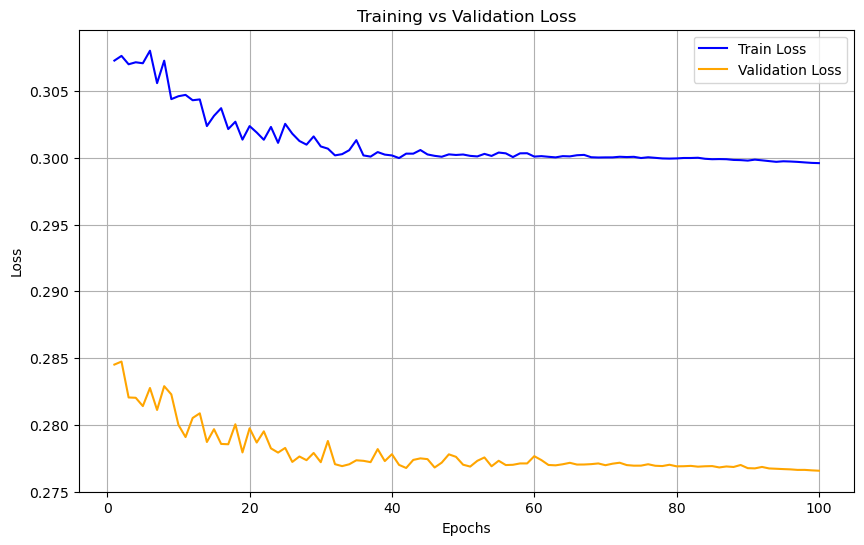

In [263]:
# Lists to store losses
train_losses = []
val_losses = []


epochs = 100
for epoch in range(epochs):
    # Train for one epoch
    train_loss = train(train_loader)
    train_losses.append(train_loss)

    # Validate for one epoch
    val_loss = validate(val_loader)
    val_losses.append(val_loss)

    # Print epoch progress
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

print("train_losses:",train_losses)
print("val_losses:", val_losses)
plot_losses(train_losses, val_losses)




In [ ]:
# import matplotlib.pyplot as plt
# import networkx as nx

# true_graph = nx.from_numpy_array(adj_true.cpu().numpy())
# pred_graph = nx.from_numpy_array(adj_pred.cpu().detach().numpy() > 0.5)  # Threshold for edges

# plt.figure(figsize=(10, 5))
# plt.subplot(121)
# nx.draw(true_graph, with_labels=True)
# plt.title("True Graph")

# plt.subplot(122)
# nx.draw(pred_graph, with_labels=True)
# plt.title("Predicted Graph")
# plt.show()


### visualization

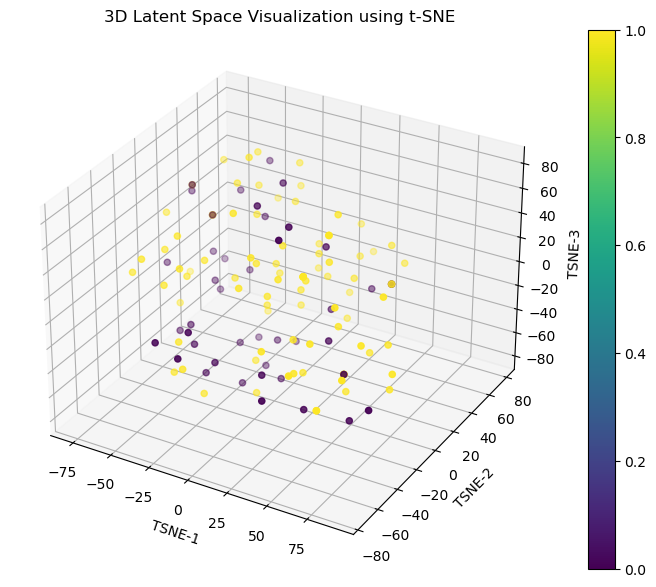

In [178]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


# Function to extract latent space from encoder
def extract_latent_space(encoder, dataloader):
    encoder.eval()  # Set encoder to evaluation mode
    latent_representations = []
    labels = []
    
    with torch.no_grad():
        for data in dataloader:
            x, edge_index, batch = data.x, data.edge_index, data.batch
            # Encode and get the latent space (mean 'mu' from encoder)
            mu, logstd = encoder(x, edge_index, batch)  # Adjust based on encoder output
            latent_representations.append(mu.detach().cpu().numpy())
            labels.append(data.y.cpu().numpy())  # labels in dataset

    latent_representations = np.concatenate(latent_representations, axis=0)
    labels = np.concatenate(labels, axis=0)  # Use this if you want to color by label class
    return latent_representations, labels

# Extract latent space representations from the trained encoder
latent_space, labels = extract_latent_space(encoder, train_loader)

# Apply t-SNE for dimensionality reduction to 3D
tsne = TSNE(n_components=3, random_state=42)
latent_space_3d = tsne.fit_transform(latent_space)

# Plot the 3D latent space
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
scatter = ax.scatter(latent_space_3d[:, 0], latent_space_3d[:, 1], latent_space_3d[:, 2], c=labels, cmap='viridis', marker='o')

# Add labels and title
ax.set_xlabel('TSNE-1')
ax.set_ylabel('TSNE-2')
ax.set_zlabel('TSNE-3')
ax.set_title('3D Latent Space Visualization using t-SNE')

# Add colorbar if you have labels to color by
plt.colorbar(scatter)

plt.show()


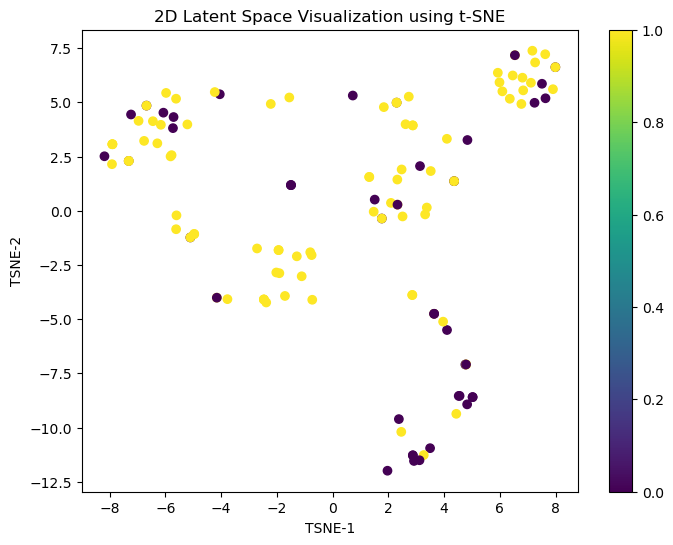

In [179]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np


# Function to extract latent space from encoder
def extract_latent_space(encoder, dataloader):
    encoder.eval()  # Set encoder to evaluation mode
    latent_representations = []
    labels = []
    
    with torch.no_grad():
        for data in dataloader:
            x, edge_index, batch = data.x, data.edge_index, data.batch
            # Encode and get the latent space (mean 'mu' from encoder)
            mu, logstd = encoder(x, edge_index, batch)  # Adjust based on encoder output
            latent_representations.append(mu.detach().cpu().numpy())
            labels.append(data.y.cpu().numpy())  # labels in dataset

    latent_representations = np.concatenate(latent_representations, axis=0)
    labels = np.concatenate(labels, axis=0)  # Use this if you want to color by label class
    return latent_representations, labels

# Extract latent space representations from the trained encoder
latent_space, labels = extract_latent_space(encoder, train_loader)

# Apply t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42)
latent_space_2d = tsne.fit_transform(latent_space)

# Plot the 2D latent space
plt.figure(figsize=(8, 6))
plt.scatter(latent_space_2d[:, 0], latent_space_2d[:, 1], c=labels, cmap='viridis', marker='o')

# Add labels and title
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.title('2D Latent Space Visualization using t-SNE')

# Add colorbar if you have labels to color by
plt.colorbar()

plt.show()


In [180]:
import torch
import torch.nn.functional as F

# Provided tensors
adj_pred = torch.tensor([[0.9963, 0.9958, 0.9906, 0.9933, 0.9890, 0.9895, 0.9632, 0.9936, 0.9928, 0.9960, 0.9769, 0.9965, 0.9956, 0.9727, 0.9972],
                         [0.9958, 0.9980, 0.9939, 0.9932, 0.9909, 0.9915, 0.9497, 0.9941, 0.9955, 0.9964, 0.9752, 0.9983, 0.9962, 0.9712, 0.9983],
                         [0.9906, 0.9939, 0.9917, 0.9919, 0.9855, 0.9849, 0.9512, 0.9920, 0.9925, 0.9916, 0.9651, 0.9943, 0.9919, 0.9598, 0.9955],
                         [0.9933, 0.9932, 0.9919, 0.9954, 0.9893, 0.9869, 0.9679, 0.9934, 0.9922, 0.9927, 0.9738, 0.9938, 0.9934, 0.9665, 0.9955],
                         [0.9890, 0.9909, 0.9855, 0.9893, 0.9859, 0.9814, 0.9551, 0.9891, 0.9886, 0.9896, 0.9616, 0.9921, 0.9894, 0.9607, 0.9927],
                         [0.9895, 0.9915, 0.9849, 0.9869, 0.9814, 0.9824, 0.9481, 0.9881, 0.9869, 0.9902, 0.9631, 0.9929, 0.9901, 0.9589, 0.9934],
                         [0.9632, 0.9497, 0.9512, 0.9679, 0.9551, 0.9481, 0.9372, 0.9686, 0.9529, 0.9642, 0.9286, 0.9550, 0.9608, 0.9274, 0.9639],
                         [0.9936, 0.9941, 0.9920, 0.9934, 0.9891, 0.9881, 0.9686, 0.9952, 0.9937, 0.9948, 0.9698, 0.9949, 0.9931, 0.9712, 0.9961],
                         [0.9928, 0.9955, 0.9925, 0.9922, 0.9886, 0.9869, 0.9529, 0.9937, 0.9946, 0.9940, 0.9652, 0.9959, 0.9935, 0.9660, 0.9966],
                         [0.9960, 0.9964, 0.9916, 0.9927, 0.9896, 0.9902, 0.9642, 0.9948, 0.9940, 0.9969, 0.9747, 0.9970, 0.9950, 0.9742, 0.9976],
                         [0.9769, 0.9752, 0.9651, 0.9738, 0.9616, 0.9631, 0.9286, 0.9698, 0.9652, 0.9747, 0.9535, 0.9784, 0.9777, 0.9408, 0.9816],
                         [0.9965, 0.9983, 0.9943, 0.9938, 0.9921, 0.9929, 0.9550, 0.9949, 0.9959, 0.9970, 0.9784, 0.9987, 0.9967, 0.9749, 0.9986],
                         [0.9956, 0.9962, 0.9919, 0.9934, 0.9894, 0.9901, 0.9608, 0.9931, 0.9935, 0.9950, 0.9777, 0.9967, 0.9963, 0.9743, 0.9971],
                         [0.9727, 0.9712, 0.9598, 0.9665, 0.9607, 0.9589, 0.9274, 0.9712, 0.9660, 0.9742, 0.9408, 0.9749, 0.9743, 0.9426, 0.9774],
                         [0.9972, 0.9983, 0.9955, 0.9955, 0.9927, 0.9934, 0.9639, 0.9961, 0.9966, 0.9976, 0.9816, 0.9986, 0.9971, 0.9774, 0.9988]])
print(adj_pred.shape)


adj_true = torch.tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
                         [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                         [0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
                         [0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
                         [0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
                         [0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
                         [0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
                         [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.],
                         [0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
                         [1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
                         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.],
                         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
                         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
                         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
                         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])
print(adj_true.shape)

# BCE Loss Calculation
loss1 = F.binary_cross_entropy(adj_true, adj_pred)
print(loss1.item())

loss2 = F.binary_cross_entropy(adj_pred,adj_true)
print(loss2.item())


loss_fn = nn.BCEWithLogitsLoss()
# Calculate BCE loss
loss3 = loss_fn(adj_true, adj_pred)

print("Binary Cross-Entropy Loss3:", loss3.item())

torch.Size([15, 15])
torch.Size([15, 15])
83.6541748046875
3.818040132522583
Binary Cross-Entropy Loss3: 0.6384369730949402


In [181]:
import torch
import torch.nn.functional as F

# Provided tensors
adj_pred = torch.tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
print(adj_pred.shape)
adj_true = torch.tensor([[0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])
print(adj_true.shape)

# BCE Loss Calculation
loss = F.binary_cross_entropy(adj_true, adj_pred)
print(loss.item())



# Loss function
loss_fn = nn.BCEWithLogitsLoss()

# Calculate BCE loss
loss3 = loss_fn(adj_true, adj_pred)

print("Binary Cross-Entropy Loss3:", loss3.item())

torch.Size([16, 16])
torch.Size([16, 16])
86.71875
Binary Cross-Entropy Loss3: 0.6426936388015747
